In [ ]:
!pip install keras
!pip install tensorflow


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import re
from nltk.tokenize  import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy , CategoricalCrossentropy

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# **DATA HANDLING**

In [ ]:
df = pd.read_csv('/content/Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df.duplicated().sum()

1

In [ ]:
df['category'].mask(df['category'] == 1,'positive',  inplace=True)
df['category'].mask(df['category'] == 0,'normal',  inplace=True)
df['category'].mask(df['category'] == -1,'negative',  inplace=True)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,normal
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [ ]:
df.category.unique()

array(['negative', 'normal', 'positive', nan], dtype=object)

In [ ]:
df['category'].value_counts()

positive    72250
normal      55213
negative    35510
Name: category, dtype: int64

In [ ]:
df = df.dropna()

# **DATA VISUALIZATION**

In [ ]:
dist = df['category'].value_counts()
import plotly.graph_objects as go
def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()
ditribution_plot(x= dist.index, y= dist.values, name= 'Class Distribution train')

In [ ]:
df['category'].mask(df['category'] == 'positive',1,  inplace=True)
df['category'].mask(df['category'] == 'normal',0,  inplace=True)
df['category'].mask(df['category'] == 'negative',-1,  inplace=True)
df['category']

0         -1
1          0
2          1
3          1
4          1
          ..
162975    -1
162976    -1
162977     0
162978     0
162979     1
Name: category, Length: 162969, dtype: object

# BILSTM

In [ ]:
dfLSTM = df

In [ ]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(dfLSTM,'clean_text')

,clean_text,category
0,when modi promised minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
162975,why these crores paid neerav modi not reco...,-1
162976,dear rss terrorist payal gawar what about modi...,-1
162977,did you cover her interaction forum where she ...,0
162978,there big project came into india modi dream p...,0


In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfLSTM['clean_text'])
dfLSTM['clean_text'] = tokenizer.texts_to_sequences(dfLSTM['clean_text'])
dfLSTM['clean_text']

0         [42, 1, 303, 721, 66, 1683, 806, 1113, 40, 234...
1         [286, 16, 2, 1104, 3, 711, 16, 2, 790, 8, 37, ...
2         [24, 53, 41, 99, 37, 4, 1, 997, 21, 505, 5, 50...
3         [380, 19, 498, 4652, 105, 43, 1213, 1, 53, 125...
4         [388, 22, 809, 80, 2, 170, 921, 123, 135, 116,...
                                ...                        
162975    [32, 80, 464, 570, 2401, 1, 6, 2682, 17, 25, 2...
162976    [306, 360, 529, 12770, 9874, 24, 36, 1, 1191, ...
162977        [53, 5, 1679, 232, 2555, 7348, 117, 186, 396]
162978    [62, 180, 554, 356, 191, 7, 1, 913, 554, 15, 6...
162979    [14, 5, 256, 681, 36, 26, 32843, 117, 4804, 11...
Name: clean_text, Length: 162969, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfLSTM['clean_text'],dfLSTM['category'], test_size=0.2, random_state=40)

In [ ]:
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 130375
y_train: 130375
X_test: 32594
y_test: 32594


**Training and testing data**

In [ ]:
X_train = pad_sequences( X_train, maxlen=64 ,dtype='float32')
X_test = pad_sequences( X_test, maxlen=64 ,dtype='float32')

len(tokenizer.index_word)

100651

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

**MODEL HANDLING**

Build model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, input_length=64, output_dim=100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           10065200  
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10252115 (39.11 MB)
Trainable params: 10252115 (39.11 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [ ]:
history = model.fit(X_train , y_train ,batch_size=256, epochs=4,
                    validation_data=(X_test , y_test),callbacks=[early_stop])

Epoch 1/4
510/510 [==============================] - 439s 849ms/step - loss: 0.3892 - accuracy: 0.8466 - val_loss: 0.1646 - val_accuracy: 0.9516
Epoch 2/4
510/510 [==============================] - 429s 841ms/step - loss: 0.1148 - accuracy: 0.9666 - val_loss: 0.1260 - val_accuracy: 0.9615
Epoch 3/4
510/510 [==============================] - 433s 849ms/step - loss: 0.0670 - accuracy: 0.9797 - val_loss: 0.1172 - val_accuracy: 0.9661
Epoch 4/4
510/510 [==============================] - 432s 847ms/step - loss: 0.0460 - accuracy: 0.9860 - val_loss: 0.1157 - val_accuracy: 0.9690


Model Fit

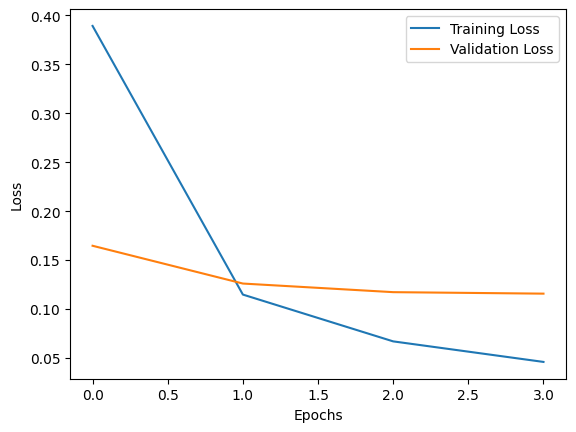

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy

In [ ]:
results4 = model.evaluate(X_test, y_test, batch_size=64)

510/510 [==============================] - 38s 75ms/step - loss: 0.1157 - accuracy: 0.9690


In [ ]:
# Save the model as LSTM(0.2).h5
model.save('LSTM(0.2).h5')

# BAG OF WORDS

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

dfBoW = df

In [ ]:
# Step 2: Convert labels to one-hot encoding using LabelEncoder
label_encoder = LabelEncoder()
dfBoW['category_encoded'] = label_encoder.fit_transform(dfBoW['category'])

In [ ]:
# Step 3: Split the data into training and testing sets
X_trainBoW, X_testBoW, y_trainBoW, y_testBoW = train_test_split(dfBoW['clean_text'], dfBoW['category_encoded'], test_size=0.2, random_state=42)

In [ ]:
# Step 4: Convert text data to Bag-of-Words representation
bow_vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed
X_train_bow = bow_vectorizer.fit_transform(X_trainBoW).toarray()
X_test_bow = bow_vectorizer.transform(X_testBoW).toarray()

In [ ]:
modelBoW = Sequential()
modelBoW.add(Dense(128, input_dim=X_train_bow.shape[1], activation='relu'))
modelBoW.add(Dense(len(set(df['category_encoded'])), activation='softmax'))
modelBoW.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelBoW.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 128515 (502.01 KB)
Trainable params: 128515 (502.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Step 8: Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Step 9: Fit the model and keep track of the training history
history = modelBoW.fit(X_train_bow, y_trainBoW, batch_size=256, epochs=4,
                    validation_data=(X_test_bow, y_testBoW), callbacks=[early_stop])

Epoch 1/4
510/510 [==============================] - 8s 12ms/step - loss: 0.6137 - accuracy: 0.7744 - val_loss: 0.5218 - val_accuracy: 0.8237
Epoch 2/4
510/510 [==============================] - 4s 8ms/step - loss: 0.4986 - accuracy: 0.8301 - val_loss: 0.5031 - val_accuracy: 0.8284
Epoch 3/4
510/510 [==============================] - 5s 10ms/step - loss: 0.4755 - accuracy: 0.8349 - val_loss: 0.4949 - val_accuracy: 0.8314
Epoch 4/4
510/510 [==============================] - 5s 10ms/step - loss: 0.4546 - accuracy: 0.8410 - val_loss: 0.4924 - val_accuracy: 0.8303


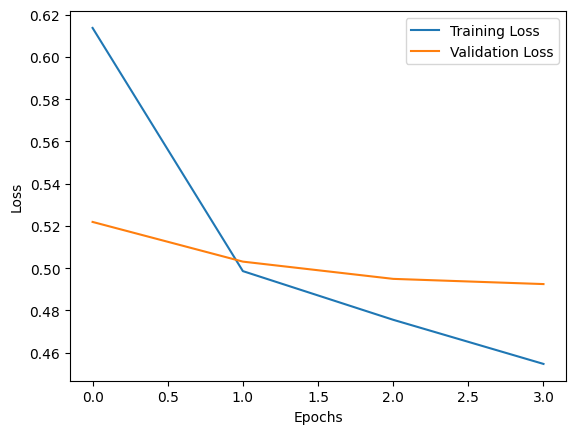

In [ ]:
# Step 10: Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
dfTFI = df
dfTFI.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,normal
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [ ]:
# Step 2: Convert labels to one-hot encoding using LabelEncoder
label_encoderTFI = LabelEncoder()
dfTFI['category_encoded'] = label_encoderTFI.fit_transform(dfTFI['category'])

In [ ]:
# Step 3: Split the data into training and testing sets
X_trainTFI, X_testTFI, y_trainTFI, y_testTFI = train_test_split(dfTFI['clean_text'], dfTFI['category_encoded'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


stop_words = 'english'

# Convert training data to TF-IDF representation
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=1)  # Adjust min_df as needed
X_train_tfidf = vectorizer.fit_transform(X_trainTFI)

# Convert testing data to TF-IDF representation
X_test_tfidf = vectorizer.transform(X_testTFI)


In [ ]:
# Step 5: Define the model
modelTFI = Sequential()
modelTFI.add(Dense(128, input_dim=X_train_tfidf.shape[1], activation='relu'))
modelTFI.add(Dense(len(set(df['category_encoded'])), activation='softmax'))  # Output layer with softmax for multiclass classification


In [ ]:
# Step 6: Compile the model
modelTFI.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Step 7: Display model summary
modelTFI.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11852800  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11853187 (45.22 MB)
Trainable params: 11853187 (45.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Step 8: Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Step 9: Fit the model and keep track of the training history
# Convert sparse matrices to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Fit the model and keep track of the training history
history = modelTFI.fit(X_train_dense, y_trainTFI, batch_size=256, epochs=4,
                       validation_data=(X_test_dense, y_testTFI), callbacks=[early_stop])

In [ ]:
# Step 10: Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()